# d2spike: Tutorial 1

## Quick look at despiking a 1D series without much interpretation

We will remove spikes from a moderately affected 1D (time) series. Notes will include where the user can add their preferred methods / changes.

In [1]:
import numpy as np
import xarray as xr
from d2spike.despike import D2spikearray
import d2spike as d2s
import matplotlib.pyplot as plt

In [2]:
t = np.arange(1000)
t_date = t * np.timedelta64(1, 's') + np.datetime64('2020-01-01')
y = 2*np.sin(2*np.pi*t/100) + np.sin(5*np.pi*t/100)
y_iid = np.random.normal(0, 0.1, size=t.size)
y_n = np.random.binomial(1, 0.2, size=t.size)
y_i = np.random.binomial(1, 0.4, size=t.size)
y_n[y_i==1] = y_n[y_i==1] * -1
y_spike = y + y_n + y_iid
y_xr = xr.DataArray(y_spike, dims=('time',), coords={'time': t_date})

In [3]:
print('Number of spikes = ' + str(np.sum(np.abs(y_n))) + '/ 1000')

Number of spikes = 207/ 1000


### View the data in 1D

Package functions can be accessed via xarray using `.floatda`

The inspection function `plot_uts` shows the series with despike removal. 

Note all plotting functions return (fig, ax) if you need. All other functions return an xarray.DataArray object so no changes are done "inplace". 

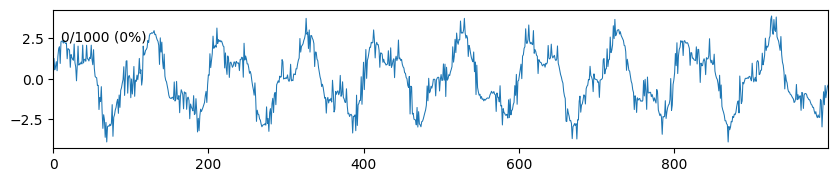

In [4]:
# Initialise the d2spike object (this can also be initialised by calling any of the non-plotting methods)
y_da = y_xr.copy()

# Plot the data with index values on the x-axis
_=y_da.floatda.plot_uts()

### Remove any low correlation data or unphysical values (optional steps)

If the instrument supplies a supplementary measure of data quality, such as correlation, that can be used to weed out likely bad data. We don't have that here.

Obviously unphysical values can be removed as well. Let's remove values over $\pm$ 3.5

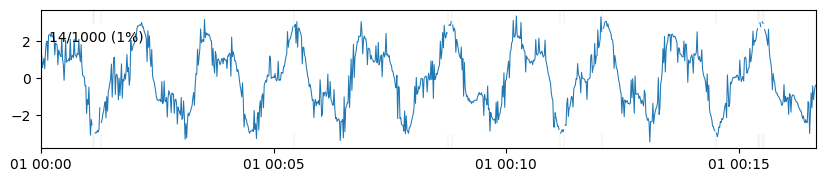

In [6]:
y_da = y_da.floatda.qc0_flags(val=3.5)

# Plot the data with time on the x-axis
_=y_da.floatda.plot_uts(index=False)

### Removing the background process

This is the most difficult and most important part of the method. Here we use the supplied gaussian filter which can handle NaN values. A lowpass filter is also supplied via `afloat` which cannot handle NaN. Users can implement any filter they think is appropriate, noting that it should aim to remove most variation above the sampling frequency. Even `np.diff` might be a good filter.

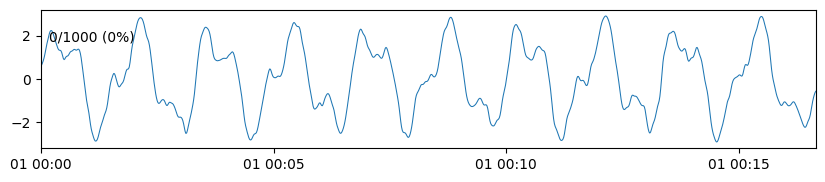

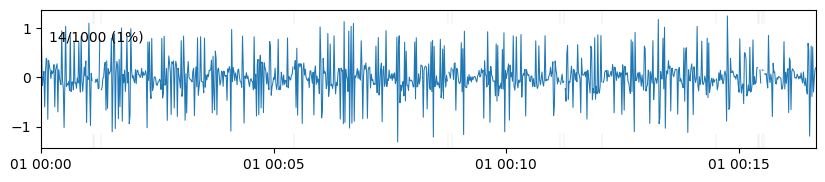

In [7]:
y_lp = y_da.floatda.gaussian_filter(2)
y_hp = y_da - y_lp

_=y_lp.floatda.plot_uts(index=False)
_=y_hp.floatda.plot_uts(index=False)

SW stat: 0.943, p value: 0.0
SW stat: 0.932, p value: 0.0
SW stat: 0.964, p value: 0.0
Non-Gaussian finishing point detected... increasing intensity to 
0.95
SW stat: 0.943, p value: 0.0
SW stat: 0.931, p value: 0.0
SW stat: 0.961, p value: 0.0
Non-Gaussian finishing point detected... increasing intensity to 
0.95
SW stat: 0.943, p value: 0.0
SW stat: 0.93, p value: 0.0
SW stat: 0.959, p value: 0.0
Non-Gaussian finishing point detected... increasing intensity to 
0.95
SW stat: 0.944, p value: 0.0
SW stat: 0.929, p value: 0.0
SW stat: 0.959, p value: 0.0
Non-Gaussian finishing point detected... increasing intensity to 
0.95
SW stat: 0.943, p value: 0.0
SW stat: 0.93, p value: 0.0
SW stat: 0.956, p value: 0.0
Non-Gaussian finishing point detected... increasing intensity to 
0.95
SW stat: 0.944, p value: 0.0
SW stat: 0.93, p value: 0.0
SW stat: 0.955, p value: 0.0
Non-Gaussian finishing point detected... increasing intensity to 
0.95
SW stat: 0.943, p value: 0.0
SW stat: 0.929, p value: 0

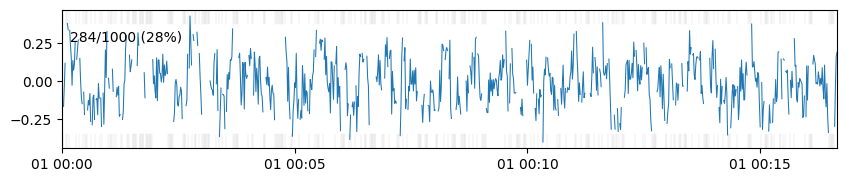

In [9]:
w_gn, _ = y_hp.floatda.despike_gn23(full_output=False, sw_thresh=0.99)
_=w_gn.floatda.plot_uts(index=False)

Goring-Nikora removes too many data points - the 'shoulders' of the spikes are removed as well.

Let's find them and put them back.

(<Figure size 1000x180 with 1 Axes>, <Axes: >)

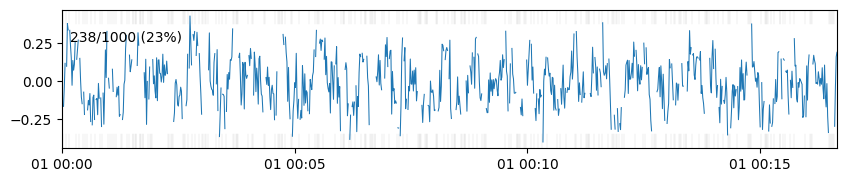

In [10]:
# indexing reinstatement
re_ix = np.abs(y_hp) < 0.35
w_gn = w_gn.floatda.reinstate_threshold((y_hp), re_ix)
w_gn.floatda.plot_uts(index=False)

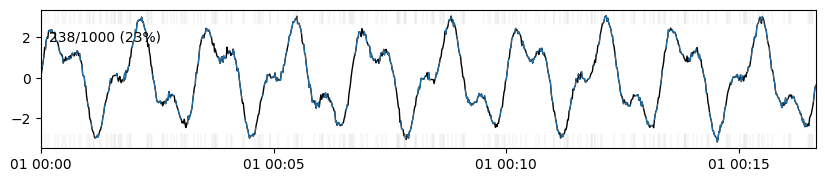

In [11]:
fig, ax = (w_gn + y_lp).floatda.plot_uts(index=False)
ax.plot(t_date, y+y_iid, color='k', lw=1, label='True signal', zorder=1)

With this setup we have removed all the spikes and kept the *iid* noise behaviour. There is a bit of an art to the reinstatement, but it should work for many cases of the same type once you have nailed it. For more difficult data we would repeat the process another time with a much smaller reinstatement value. 

We have removed about 2-3% more data points than the original spikes, but the data is now spike free.

Leaving in the NaN or interpolating is left to the user. 